# Forecast weekly gross for Majestic Theatre using SARIMA

The Seasonal Autoregressive Integrated Moving Average (SARIMA) is an enhancement to the ARIMA model for handling seasonality. Like an ARIMA(p, d, q), a SARIMA model also requires (p, d, q) to represent non-seasonal orders. Additionally, a SARIMA model requires the orders for the seasonal component, which is denoted as (P, D, Q, S). Combining both components, the model can be written as a SARIMA(p, d, q)(P, D, Q, s). The letters still mean the same, and the letter case indicates which component. For example, the lowercase letters represent the non-seasonal orders, while the uppercase letters represent the seasonal orders. The new parameter, S, is the number of steps per cycle – for example, S=12 for monthly data or S=4 for quarterly data.


## Import Statements

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pmdarima as pm
import seaborn as sns

from pylab import rcParams
from itertools import product

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse # Root Mean Square Error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

## Notebook Settings

In [3]:
warnings.filterwarnings("ignore")  # hide warnings
sns.set_style("whitegrid")
#plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [18, 10]

## Useful Functions

In [4]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

## Get the Data

In [5]:
filepath = '../DATA-COLLECTION/grosses.csv'
data = pd.read_csv(filepath,
                 header=0,
                 parse_dates=['week_ending'],
                 index_col=0,
                 usecols=['week_ending','theatre','weekly_gross'])

In [6]:
majestic_df = data[(data['theatre'] == 'Majestic Theatre')]

In [7]:
majestic_df.drop(['theatre'], axis=1, inplace = True) 

In [8]:
### We will use data for Majestic Theatre from 2013-06-02 to 2019-05-26.
start_date = '2013-06-02'
#end_date = '2018-05-27'
end_date = '2019-05-26'
majestic_df = majestic_df.loc[start_date : end_date]
majestic_df = majestic_df.asfreq('W')
majestic_df.head(1)

,weekly_gross
week_ending,
2013-06-02,1100715.0


In [9]:
majestic_df[majestic_df['weekly_gross'].isna()]

,weekly_gross
week_ending,
2015-12-27,NaN


In [10]:
majestic_df = majestic_df.fillna(method='ffill')

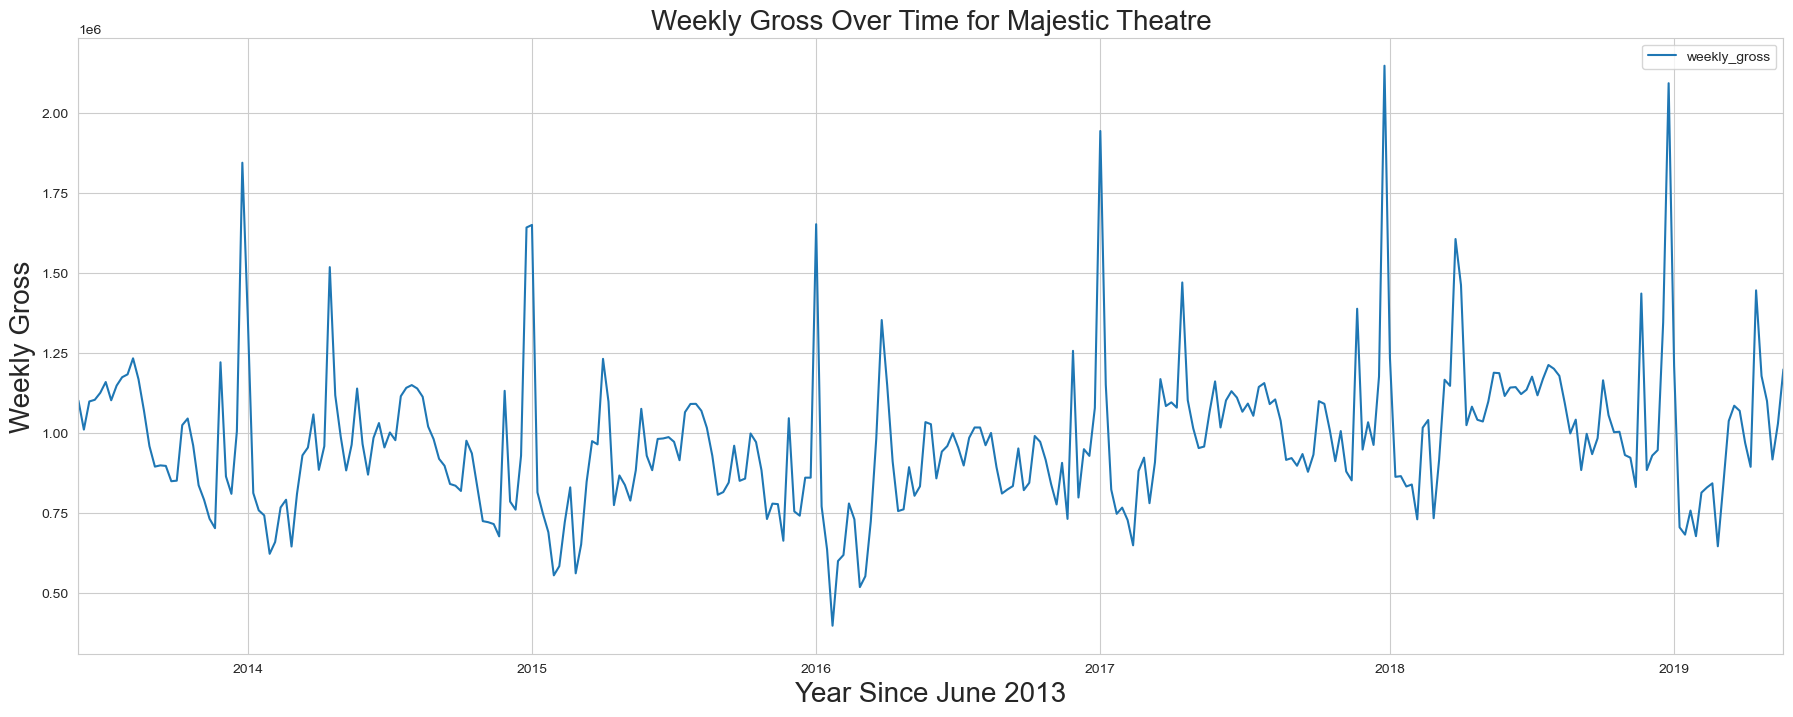

In [11]:
# plot the time series
majestic_df.plot(figsize = (22,8))
plt.xlabel('Year Since June 2013', fontsize=20)
plt.ylabel('Weekly Gross', fontsize=20)
plt.title("Weekly Gross Over Time for Majestic Theatre", fontsize=20)
plt.savefig('../img/majestic_series.png')
plt.show()

The time series plot shows a repeating seasonality (every winter, towards the end of the year). The seasonality fluctuations don't seem to increase over time, indicating an additive model.

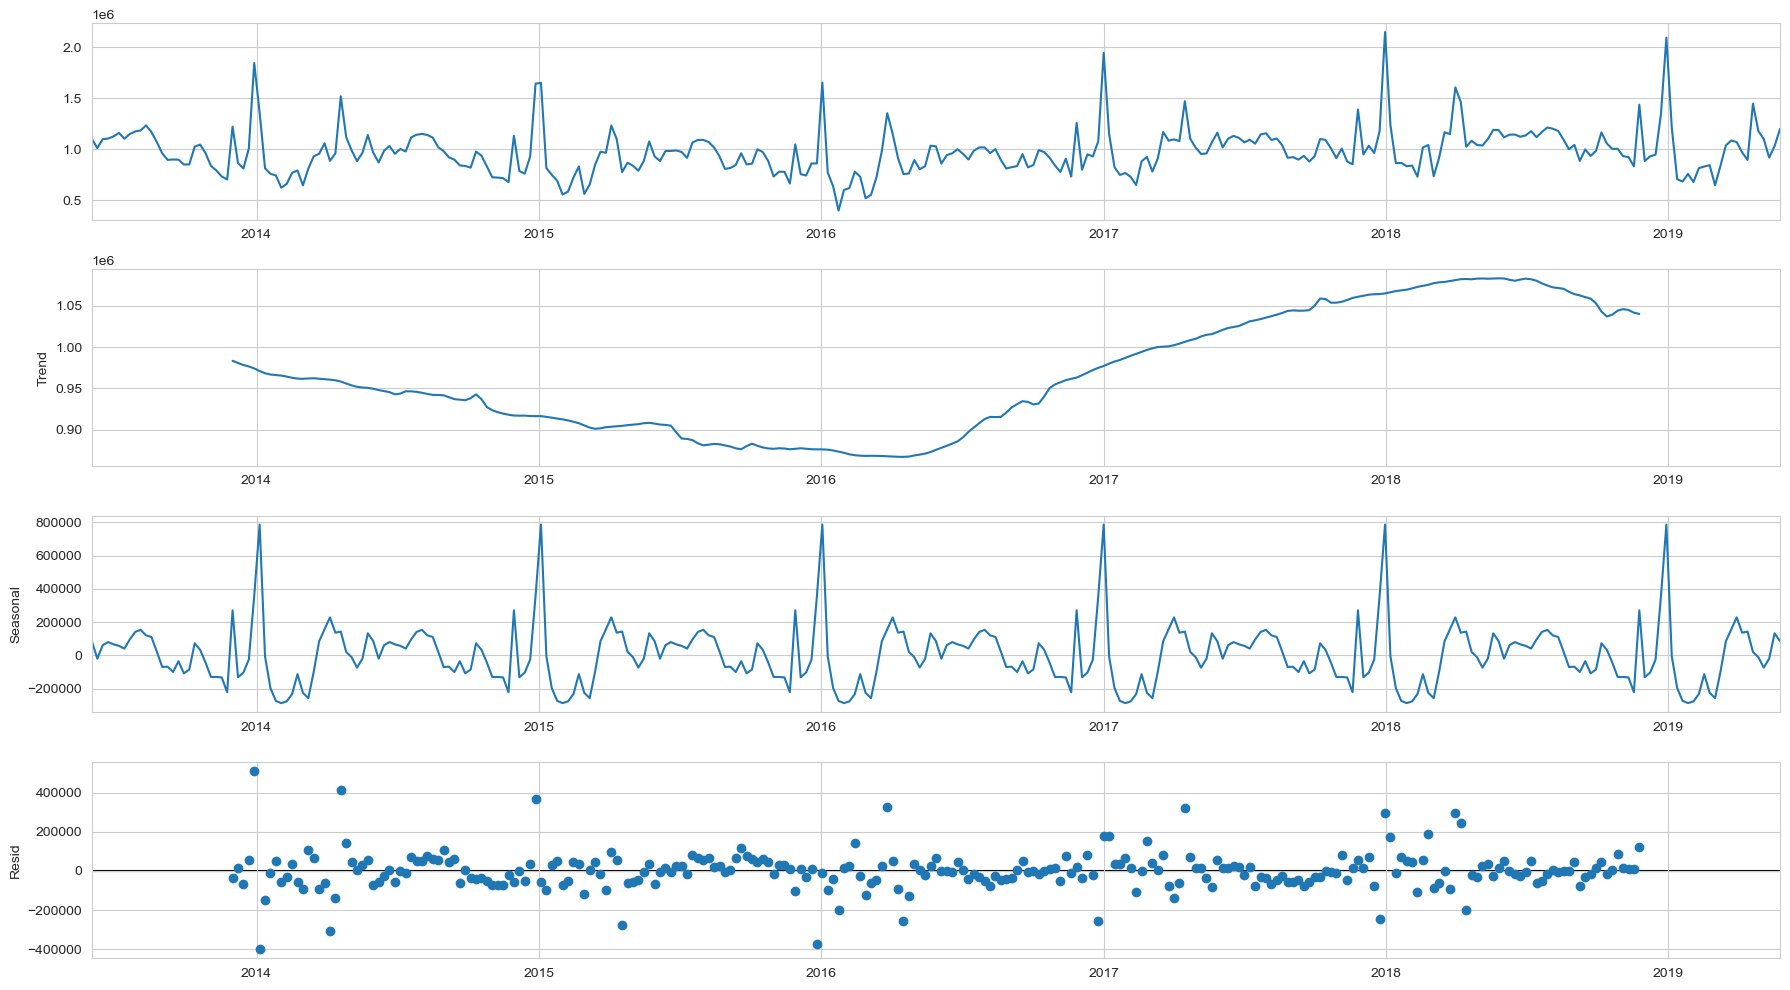

In [12]:
decomposition = seasonal_decompose(majestic_df, model='additive')
fig = decomposition.plot()
fig.savefig('../img/seasonal_decomp_majestic.png')
plt.show()

In [13]:
# Split the data into train and test sets using the train_test_split function from pmdarima
train, test = pm.model_selection.train_test_split(majestic_df,test_size=0.165)
print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

Train: (261, 1)
Test: (52, 1)


In [14]:
test.head(1)

,weekly_gross
week_ending,
2018-06-03,1115092.1


In [15]:
test.tail(1)

,weekly_gross
week_ending,
2019-05-26,1198078.32


There are 261 weeks in the training set and 52 weeks in the test set. We will use the test set to evaluate the model using out-of-sample data.

## SARIMA using `statsmodels`'s `SARIMAX` class

In `statsmodels`, you will use the [SARIMAX](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) class to build a SARIMA model.

We can perform a naive grid search by evaluating different combinations of the (p, d, q) and (P, D, Q, S) parameters to pick the best model.

We set S = 52 (assume yearly seasonality for weekly data).

Note that automated time series libraries support this naive brute force grid search over combinations. We'll explore `auto_arima` later in this notebook.

In [30]:
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

P_ns, D_ns, Q_ns = [list(range(2))]*3
P_s, D_s, Q_s = [list(range(2))]*3
vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},52)')
    try:    
        m = SARIMAX(train,
                    order=(p,d,q),
                    seasonal_order=(P, D, Q, 52),
                    enforce_stationarity=False, # avoid a LinAlgError
                    enforce_invertibility=False
                   )
        res = m.fit(disp=0)
    except:
        continue
    y = test.values.ravel()
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic, # Akaike's Information Criteria
                'RMSE' : rmse(y, y_hat), # Root Mean Square Error
                'MSE' : mse(y, y_hat),  # Mean Square Error
                'MAE' : mae(y, y_hat), # Mean Absolute Error
                'MAPE' : mape(y, y_hat), # Mean Absolute Percentage Error
                'model': res
               }

Running model #0 using SARIMA(0,0,0)(0,0,0,52)
Running model #15 using SARIMA(0,0,1)(1,1,1,52)
Running model #30 using SARIMA(0,1,1)(1,1,0,52)
Running model #45 using SARIMA(1,0,1)(1,0,1,52)
Running model #60 using SARIMA(1,1,1)(1,0,0,52)


In [31]:
best_model_rmse = get_best_model(score, 'RMSE')

Best model: 35 with lowest RMSE score: 133343.49486987744


In [32]:
best_model_rmse = score[35]['model']
print('ARIMA' + str(score[35]['non-seasonal order']) + str(score[35]['seasonal order']) +'[52]')

ARIMA(1, 0, 0)(0, 1, 1)[52]


In [33]:
best_model_rmse.model

In [34]:
### Get model scores
score[35]

{'non-seasonal order': (1, 0, 0),
 'seasonal order': (0, 1, 1),
 'AIC': 4146.817292010124,
 'RMSE': 133343.49486987744,
 'MSE': 17780487624.11303,
 'MAE': 101572.29428423477,
 'MAPE': 0.10093541784594612,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fa20fd6b8b0>}

In [35]:
best_model_rmse.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         weekly_gross   No. Observations:                  261
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 52)   Log Likelihood               -2070.409
Date:                              Thu, 01 Jun 2023   AIC                           4146.817
Time:                                      19:30:25   BIC                           4155.967
Sample:                                  06-02-2013   HQIC                          4150.533
                                       - 05-27-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4577      0.047      9.711      0.000       0.365       0.550
ma.S.L52      -0.2530      0.033     -7.655      0.000      -0.318      -0.188
sigma2       2.12e+10   6.05e-13    3.5e+22      0.000    2.12e+10    2.12e+10
===================================================================================
Ljung-Box (L1) (Q):                   2.39   Jarque-Bera (JB):               532.31
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.25
Prob(H) (two-sided):                  0.36   Kurtosis:                        12.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

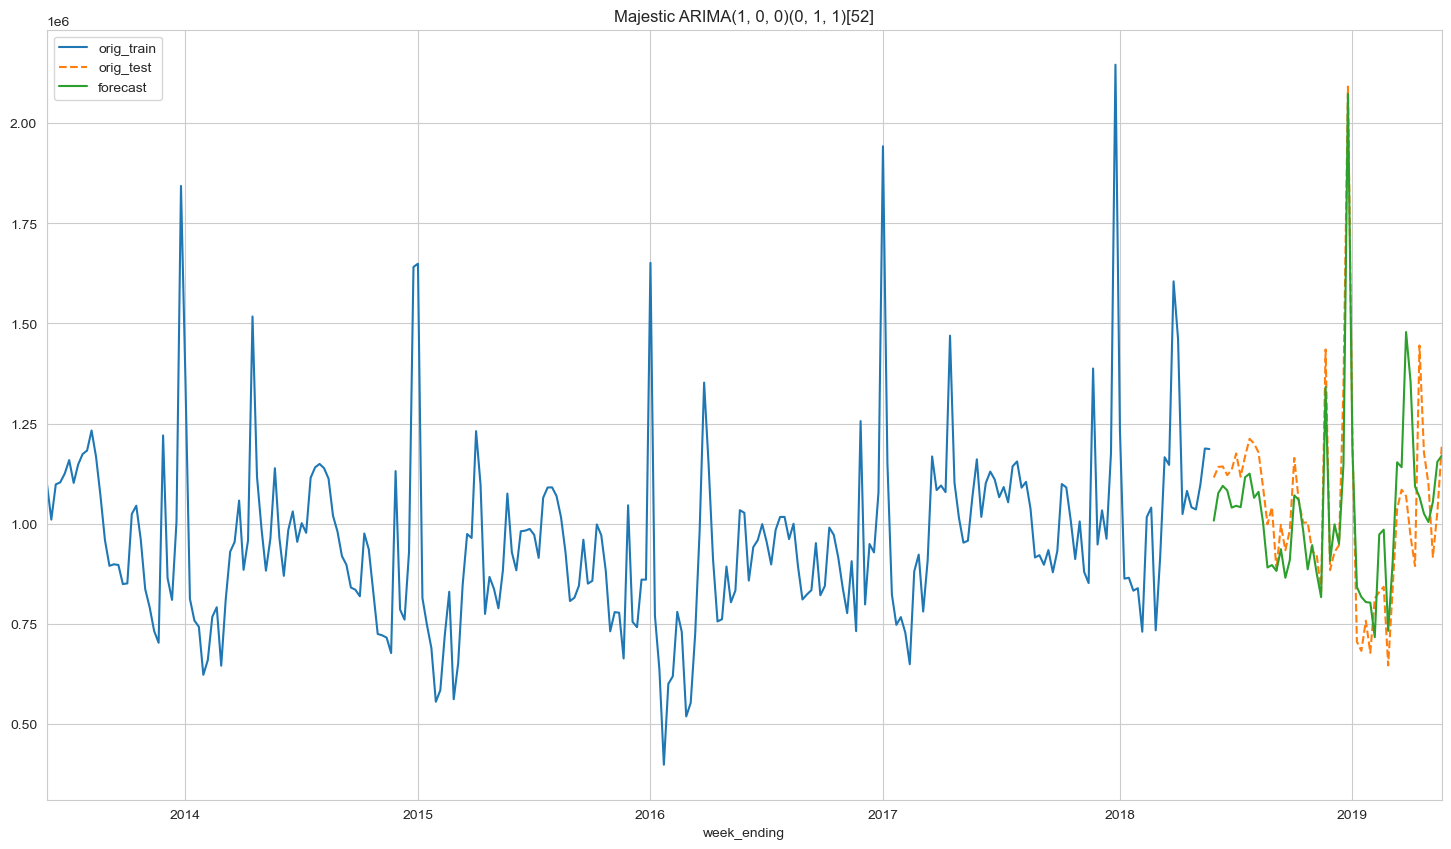

In [55]:
forecast = pd.DataFrame(best_model_rmse.forecast(test.shape[0]),index=test.index)
ax = train.loc[start_date:].plot(style='-')
test.plot(ax=ax, style='--')
forecast.plot(ax=ax)
ax.legend(['orig_train', 'orig_test', 'forecast'])
plt.title('Majestic ARIMA(1, 0, 0)(0, 1, 1)[52]')
plt.savefig('../img/Majestic ARIMA(1, 0, 0)(0, 1, 1)[52].png')
plt.show()

In [75]:
model = pm.arima.ARIMA(order=(1, 0, 0),seasonal_order=(0,1,1,52),with_intercept=False)
model.fit(train)

ARIMA(order=(1, 0, 0), seasonal_order=(0, 1, 1, 52), with_intercept=False)

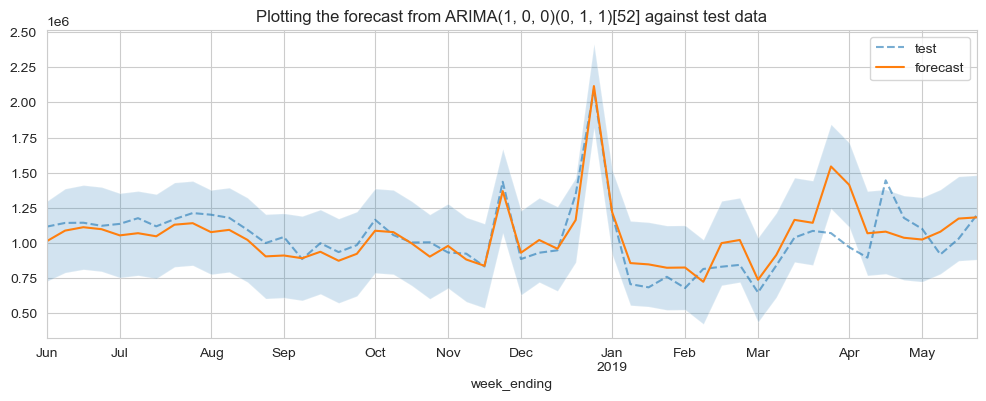

In [76]:
n = test.shape[0]
forecast, conf_interval = model.predict(n_periods=n,return_conf_int=True)
lower_ci, upper_ci  = zip(*conf_interval)
index = test.index
ax = test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(forecast, index=index).plot(style='-', ax=ax)
plt.fill_between(index, lower_ci, upper_ci, alpha=0.2)
plt.legend(['test', 'forecast'])
plt.title("Plotting the forecast from ARIMA(1, 0, 0)(0, 1, 1)[52] against test data")
plt.savefig("../img/Majestic ARIMA(1, 0, 0)(0, 1, 1)[52].png")
plt.show() 

In [77]:
y = test.values.ravel()
predictions = model.predict(test.shape[0]).values
print('RMSE:', rmse(y, predictions)) # Root Mean Square Error
print('MSE:', mse(y, predictions)) # Root Mean Square Error
print('MAE:', mae(y, predictions)) # Mean Absolute Error
print('MAPE:', mape(y, predictions))  # Mean Absolute Percentage Error

RMSE: 139861.35879502798
MSE: 19561199683.991547
MAE: 102447.70695518717
MAPE: 0.10356388153205758


## SARIMA using `auto_arima` from `pmdarima`

You must install `pmdarima`, a Python library that includes `auto_arima` for automating ARIMA hyperparameter optimization and model fitting. To install it using pip, use the following command:

<code> pip install pmdarima </code>

To install it using conda, use the following command: 

<code> conda install -c conda-forge pmdarima</code> 



We will use the [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) function from `pmdarima` to optimize and find the best configuration for our SARIMA model. Prior knowledge about our data is key to obtaining the best results from auto_arima. We know the data has a seasonal pattern, so we need to provide values for the two parameters: `seasonal=True` and `m=52` or `m=53` (yearly seasonality for weekly data).

If these values are not set, the model will only search for the non-seasonal orders (p, d, q).
The `test` parameter specifies the type of unit root test to use to detect stationarity to determine the differencing order (d). The default test is `kpss`. Similarly, `seasonal_test` is used to determine the order (D) for seasonal differencing. The default seasonal_test is `OCSB`, which we will keep as-is.

The best model is selected based on [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion), which is controlled by the `information_criterion` parameter. This can be changed to any of the four supported information criterias: `aic` (default), `bic`, `hqic`, and `oob`.

Instead of the naive approach of training multiple models through grid search to cover every possible combination of parameter values, `auto_arima` automates the process for finding the optimal parameters. The `auto_arima` function uses a stepwise algorithm that is faster and more efficient than a full grid search or random search:

* When `stepwise=True`, auto_arima performs a stepwise search (which is the default).
* With `stepwise=False`, it performs a brute-force grid search (full search).
* With `random=True`, it performs a random search.

In [28]:
# If you want to observe the score of the trained model at each iteration, you can use trace=True
auto_model_1 = pm.auto_arima(train,
                           seasonal=True,
                           m=52,
                           test='kpss',
                           stepwise=True,
                           trace=True,
                           random_state=100)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=7013.795, Time=6.62 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=7167.883, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=7038.489, Time=0.75 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=7041.859, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=7947.038, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=7011.851, Time=4.90 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=7103.803, Time=0.07 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=7013.794, Time=25.62 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=inf, Time=32.98 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=7011.831, Time=2.40 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=7101.837, Time=0.03 sec
 ARIMA(1,0,2)(2,0,0)[52] intercept   : AIC=7013.818, Time=9.74 sec
 ARIMA(1,0,2)(1,0,1)[52] intercept   : AIC=7013.830, Time=2.87 sec
 ARIMA(1,0,2)(0,0,1)[52] in

In [27]:
auto_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  261
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 52)   Log Likelihood               -3499.915
Date:                             Thu, 01 Jun 2023   AIC                           7011.831
Time:                                     18:19:26   BIC                           7033.218
Sample:                                 06-02-2013   HQIC                          7020.428
                                      - 05-27-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.249e+05   4.04e+05      1.301      0.193   -2.66e+05    1.32e+06
ar.L1         -0.3870      1.088     -0.356      0.722      -2.520       1.746
ma.L1          0.8359      1.067      0.783      0.434      -1.256       2.928
ma.L2          0.2400      0.418      0.575      0.566      -0.579       1.059
ar.S.L52       0.6165      0.047     13.192      0.000       0.525       0.708
sigma2      3.793e+10      5.929    6.4e+09      0.000    3.79e+10    3.79e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               330.46
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.96
Prob(H) (two-sided):                  0.17   Kurtosis:                         8.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.29e+25. Standard errors may be unstable.
"""

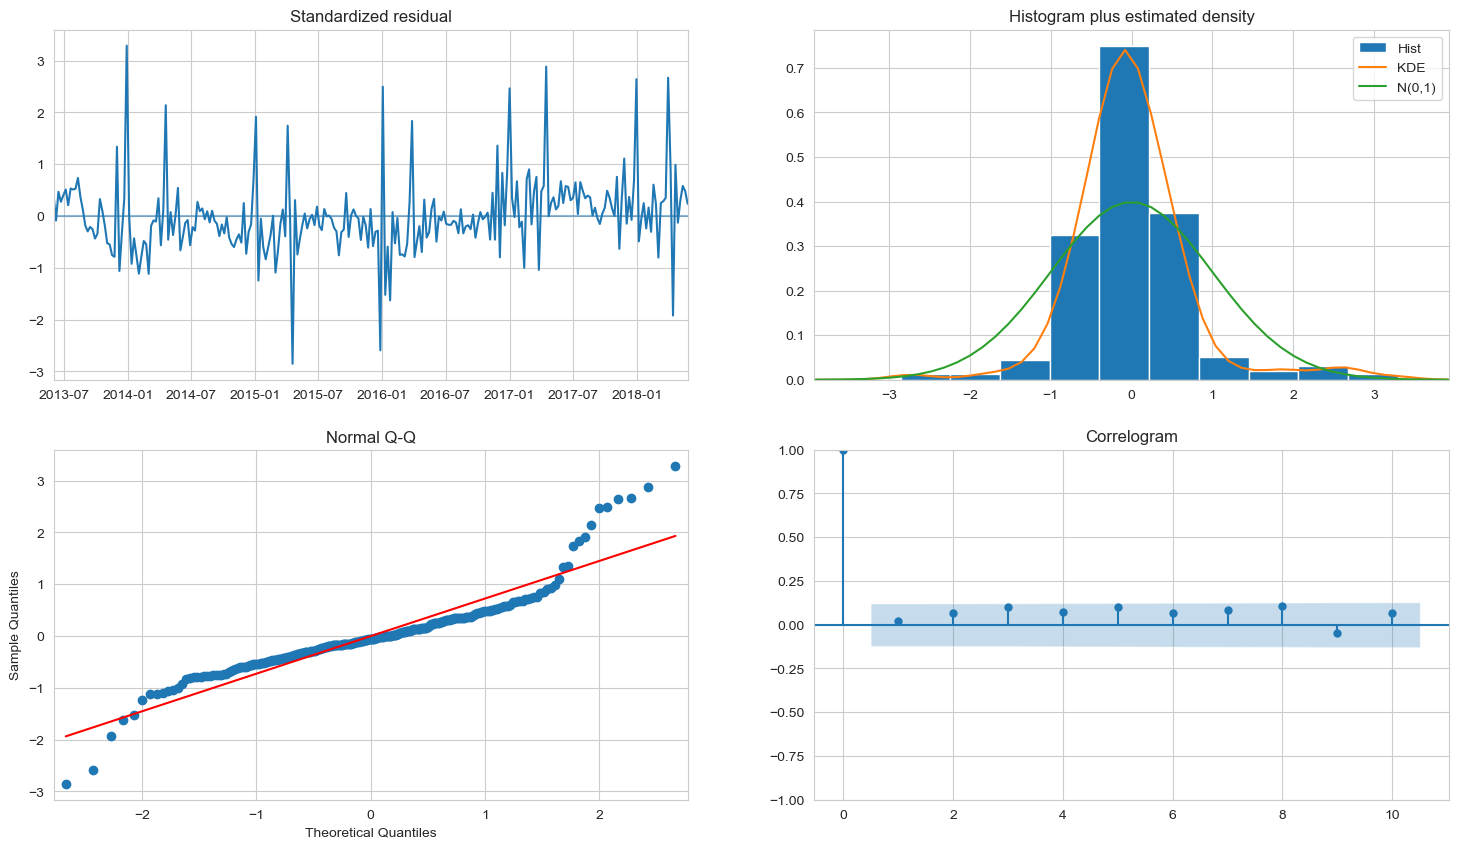

In [28]:
auto_model_1.plot_diagnostics()
plt.show()

`auto_model_1` stored the winning SARIMA model. To make a prediction, you can use the `predict` method. You need to provide the number of periods to forecast forward into the future. You can obtain the confidence intervals with the prediction by updating the `return_conf_int parameter` from `False` to `True`. This allows you to plot the lower and upper confidence intervals using matplotlib's `fill_between` function. The following code uses the predict method, returns the confidence intervals, and plots the predicted values against the test set:

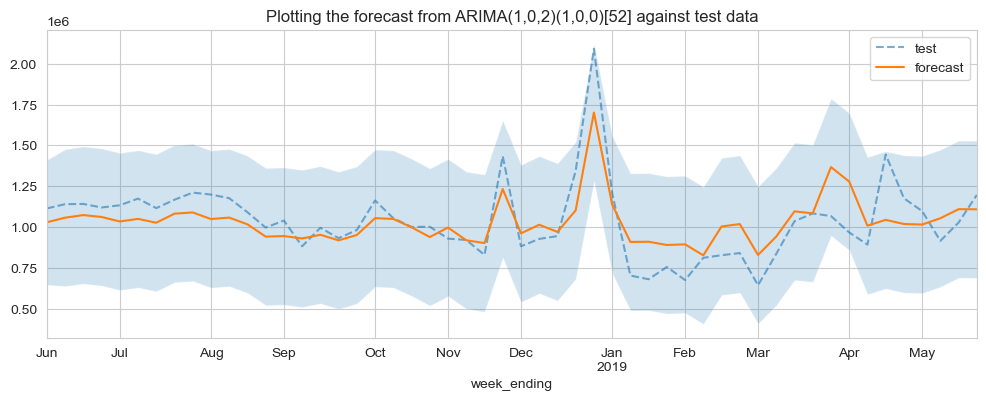

In [29]:
n = test.shape[0]
forecast, conf_interval = auto_model_1.predict(n_periods=n,return_conf_int=True)
lower_ci, upper_ci  = zip(*conf_interval)
index = test.index
ax = test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(forecast, index=index).plot(style='-', ax=ax)
plt.fill_between(index, lower_ci, upper_ci, alpha=0.2)
plt.legend(['test', 'forecast'])
plt.title("Plotting the forecast from ARIMA(1,0,2)(1,0,0)[52] against test data")
plt.savefig("../img/ARIMA(1,0,2)(1,0,0)[52].png")
plt.show() 

The default confidence interval is set to 95% and can be controlled using the alpha parameter (`alpha=0.05`, which is 95% confidence interval) from the `predict()` method. The shaded area represents the likelihood that the real values would lie between this range. Ideally, you would prefer a narrower confidence interval range. Notice that the forecast line lies in the middle of the shaded area. This represents the mean of the upper and lower bounds.

In [30]:
y = test.values.ravel()
predictions = auto_model_1.predict(test.shape[0]).values
print('RMSE:', rmse(y, predictions)) # Root Mean Square Error
print('MSE:', mse(y, predictions)) # Root Mean Square Error
print('MAE:', mae(y, predictions)) # Mean Absolute Error
print('MAPE:', mape(y, predictions))  # Mean Absolute Percentage Error

RMSE: 147299.48848651443
MSE: 21697139308.388798
MAE: 116006.18406011435
MAPE: 0.11429377632621386


### Run `auto_arima` with more constraints

[auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) gives you more control over the evaluation process by providing a min and max constraints. 

For example, you can provide min and max constraints for the non-seasonal autoregressive order, p, or the seasonal moving average, Q. If you run the code below, auto_arima will create different models for every combination of the parameter values based on the constraints you provided.

In [24]:
auto_model_2 = pm.auto_arima(train,
                      seasonal=True,
                      with_intercept=True,
                      d=0,
                      max_d=1,
                      start_p=0, max_p=2,
                      start_q=0, max_q=2,
                      m=52,
                      D=0,
                      max_D=1,
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2,
                      information_criterion='aic',
                      stepwise=True,
                      out_of_sample_size=25,
                      test = 'adf',
                      score='rmse',
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=7171.513, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=7029.057, Time=2.19 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=7947.199, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=7102.602, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=7025.076, Time=11.45 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=26.20 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=7003.275, Time=2.75 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=7003.268, Time=8.69 sec
 ARIMA(1,0,0)(0,0,2)[52] intercept   : AIC=7004.780, Time=7.33 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=28.77 sec
 ARIMA(0,0,0)(1,0,2)[52] intercept   : AIC=7063.403, Time=7.10 sec
 ARIMA(2,0,0)(1,0,2)[52] intercept   : AIC=7004.678, Time=11.37 sec
 ARIMA(1,0,1)(1,0,2)[52] intercept 

In [25]:
auto_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  261
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 52)   Log Likelihood               -3491.882
Date:                            Thu, 01 Jun 2023   AIC                           6997.763
Time:                                    19:21:41   BIC                           7022.715
Sample:                                         0   HQIC                          7007.793
                                            - 261                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.244e+05   2.98e+05      1.758      0.079   -6.01e+04    1.11e+06
ar.L1         -0.5351      1.077     -0.497      0.619      -2.645       1.575
ar.L2          0.3947      0.436      0.904      0.366      -0.461       1.250
ma.L1          0.9466      1.088      0.870      0.384      -1.185       3.078
ar.S.L52       0.5342      0.088      6.056      0.000       0.361       0.707
ma.S.L52       0.1552      0.140      1.109      0.267      -0.119       0.430
sigma2      3.281e+10     12.295   2.67e+09      0.000    3.28e+10    3.28e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):               376.70
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                             0.87
Prob(H) (two-sided):                  0.14   Kurtosis:                         8.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.13e+24. Standard errors may be unstable.
"""

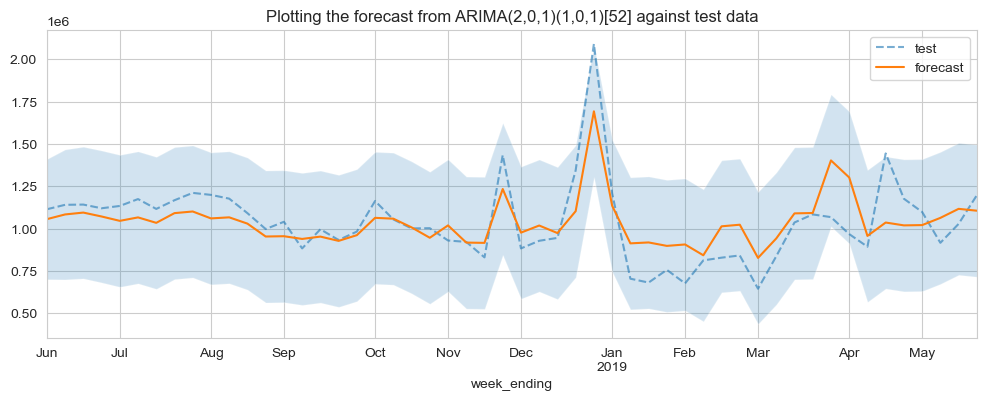

In [26]:
n = test.shape[0]
forecast, conf_interval = auto_model_2.predict(n_periods=n,return_conf_int=True)
lower_ci, upper_ci  = zip(*conf_interval)
index = test.index
ax = test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(forecast, index=index).plot(style='-', ax=ax)
plt.fill_between(index, lower_ci, upper_ci, alpha=0.2)
plt.legend(['test', 'forecast'])
plt.title("Plotting the forecast from ARIMA(2,0,1)(1,0,1)[52] against test data")
plt.savefig("../img/Majestic ARIMA(2,0,1)(1,0,1)[52].png")
plt.show()

In [27]:
y = test.values.ravel()
predictions = auto_model_2.predict(test.shape[0])
print('RMSE:', rmse(y, predictions)) # Root Mean Square Error
print('MSE:', mse(y, predictions)) # Root Mean Square Error
print('MAE:', mae(y, predictions)) # Mean Absolute Error
print('MAPE:', mape(y, predictions))  # Mean Absolute Percentage Error

RMSE: 149642.26562329536
MSE: 22392807660.872887
MAE: 114952.83124972058
MAPE: 0.11386879301918529


# Practical considerations

Although ARIMA and Auto ARIMA can give you good-performing models in many cases, they can be quite slow when you have long seasonal periods and a long time series. Letting go of the seasonal parameters brings down the runtime drastically, but for a seasonal time series, it doesn’t make sense. Auto ARIMA includes many such fits to identify the best parameters and therefore becomes impractical for long time series datasets. Almost all the implementations in the Python ecosystem suffer from this drawback except for `statsforecast` (see https://github.com/Nixtla/statsforecast and https://nixtla.github.io/statsforecast/examples/getting_started_short.html). It is a relatively new library, but it shows a lot of promise in having a fast implementation of ARIMA and AutoARIMA. 